## Mini-project: Building a 1D CNN for classification of waveforms ##

## Based on original by Dr. Antonin Vacheret


This project is about designing a 1D Convolutional Neural Net (CNN) that classifies digitised signals from two types of scintillating materials used to record particle energy. 

There are many signal processing tasks where it is important to separate the signals recorded in different categories. Due to the complex features of the signals recorded, a computer vision solution is well suited for solving this problem. 

We are dealing with two type of signals: 

* The first type of material is an organic scintillator (PVT) with a fast time response of a few nanoseconds. These fasts signals are also called Electron Scintillation (ES) signals.  

* The second type of material is an inorganic scintillator to detect neutrons (ZnS(Ag)), one of the oldest scintillators used. When a neutron is detected, the scintillation signal is a long trail of fast pulses that slowly decreases in amplitude. These slow signals are called Nuclear Scintillation (NS) signals. 

We are interested here in separating as well as possible each type of signal and therefore coming up with a model that is able to have a very high score at predicting each class of signal.

Numpy files for the training and testing datasets (xtrain.npy, ytrain.npy) and their labels are already prepared. Each digitised waveform is a 1000 samples long with recorded pulses starting at a fixed time around 250 samples. Some examples of how to look at each signals and their label is provided below. Both type of signals have their amplitude normalised to the smallest pulse detectable i.e. what we call the 1 Photo-electron pulse. 

In [323]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# choose your preferred font size and style here for plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
#plt.rcParams['font.family'] = 'Times'
#plt.rcParams['font.serif'] = 'Times'

In [324]:
# importing the datasets
xtrain = np.load("./Data/x_train.npy")
ytrain = np.load("./Data/y_train.npy")
xtest = np.load("./Data/x_test.npy")
ytest = np.load("./Data/y_test.npy")
print(xtrain.shape,xtest.shape)

(12302, 1000) (3076, 1000)


Below we are displaying a few examples from the training set to get a feel for the variability of the signal waveforms. 

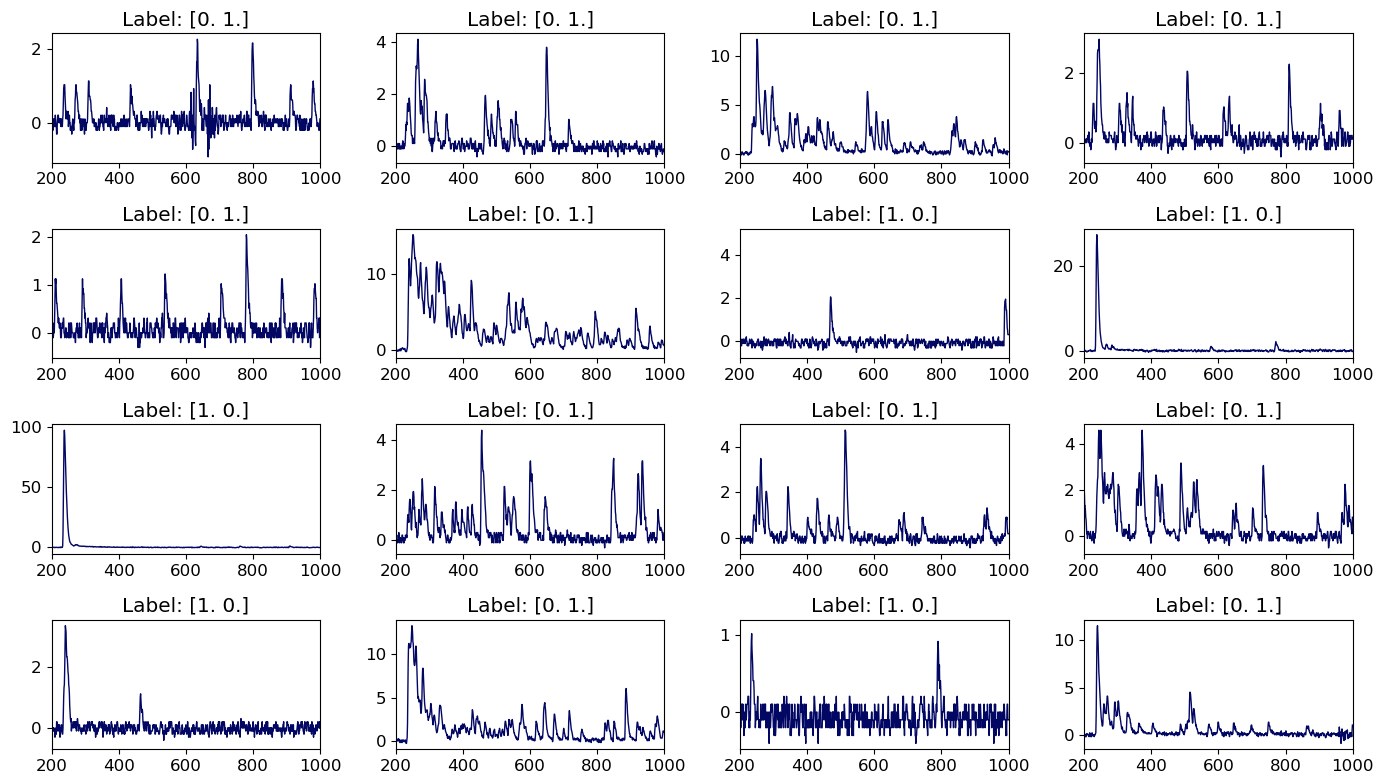

In [325]:
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.flatten()
for i in range(0, 16):
    j = np.random.randint(0, len(xtrain))
    #print(j)
    ax[i].plot(xtrain[j],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Label: {}".format(ytrain[j]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

The fast ES signals have labels ```[1,0]``` and the slower signals NS from neutrons have the other value ```[0,1]```. Notice that you can have some small pulses present later in the waveform for ES signals but generally not with the same density as NS signals.   

### Your project: Building a 1-dimensional CNN to classify the waveforms

* The relatively large differences between these two type of signals means the classification with simple pulse processing method yields an Area Under the curve (Integral of the ROC curve) of better than 95%. It is therefore expected that a well designed CNN provides an AUC > 95% with the aim to reach better than 99%.
* It is expected that datasets and dataloaders are implemented. Example of visualisation of plots showing features of the waveforms with some discussion is also expected. 
* The steps in designing and optimising the architecture should be clearly presented with a schematic of the final model architecture. It is important to explain why you have chosen some specific parameters or functions and don't hesitate the cite the literature if you have find the information in an article. 
* training/testing Loss and Accuracy and other parameters of the training should also be shown along with the final results. 
* Provide a plot with the output of the model for each class as well as the final ROC curve and AUC. 
* Feel free to add feature maps and other visualisation to support your discussion of performance and why

# List of contents
# Table of Contents
1. [Introduction](#Introduction)
2. [Model Building](#Model-Build)
3. [Test and Validation](#Test-Validation)
4. [Conclusion](#Conclusion)

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
print("Module Loaded Okay")
# To ensure the consistency, we need to set a seed
torch.seed = 42

Module Loaded Okay


## Introduction

We firstly need to split the data sets into train set, validation set and train set. Note that the reason why we need test set and validation set is that we need to fine tuning our hyperparameters based on the validation set. As a result, it might be "learning" the validation set, and thus we need to seperate the validation set and test set.

In [332]:
#define the macro we are going to use
batch_size = 5

#transfer ytrain into two scaler labels

def toScaler_binary(input_array, classes):
    output_array = []
    for i in input_array:
        current_val = 1. if (i == classes[0]).all() else 0.
        output_array.append(current_val)
    return np.array(output_array)

classifcation = [np.array([1.,0.]) , np.array([0.,1.])]
ytrain_binary = toScaler_binary(ytrain, classifcation)
ytest_binary  = toScaler_binary(ytest, classifcation)

#we firstly transfer our python dataset into pytorch tensor
tensor_xtrain = torch.tensor(xtrain, dtype = torch.double)
tensor_ytrain = torch.tensor(ytrain_binary, dtype = torch.long)
tensor_xtest  = torch.tensor(xtest, dtype = torch.double)
tensor_ytest  = torch.tensor(ytest_binary, dtype = torch.long)

#transform the data shape
tensor_xtrain = torch.reshape(tensor_xtrain,(len(tensor_xtrain),1,len(tensor_xtrain[0])))
tensor_xtest  = torch.reshape(tensor_xtest,(len(tensor_xtest),1,len(tensor_xtest[0])))

#combine the tensor into dataset
train_set = torch.utils.data.TensorDataset(tensor_xtrain, tensor_ytrain)
test_set  = torch.utils.data.TensorDataset(tensor_xtest, tensor_ytest)

#split the train set and validation set
train_set, val_set = torch.utils.data.random_split(train_set, [0.7,0.3])

#now we use the torch data loader
train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader   = torch.utils.data.DataLoader(val_set,  batch_size = batch_size, shuffle = False, num_workers = 2)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 2)

#two classes
classes = ("ES","NS")


Before we will train the model, let us first consider the effect of the convolutional kernel and see what kind of feature that we can pick up by manually varying the kernel.

In [333]:
#load a test data
feature_loader = torch.utils.data.DataLoader(train_set, batch_size = 1, shuffle = True)
featureiter = iter(feature_loader)
data, label = next(featureiter)

#construct the convolutional neural network manually
#this is a weight that detects a peak, and its dimensionality is 19
weights = torch.tensor([[[0. + i for i in range(0,10)] + [10.] + [10. - i for i in range(0,10)]]])
conv = nn.Conv1d(1,1,len(weights))
conv.weight = nn.Parameter(weights)

data = torch.tensor(data, dtype = conv.weight.dtype)
output = conv(data)

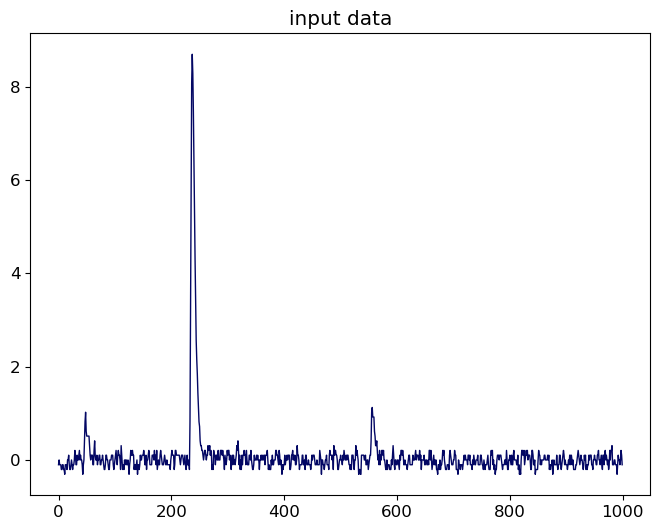

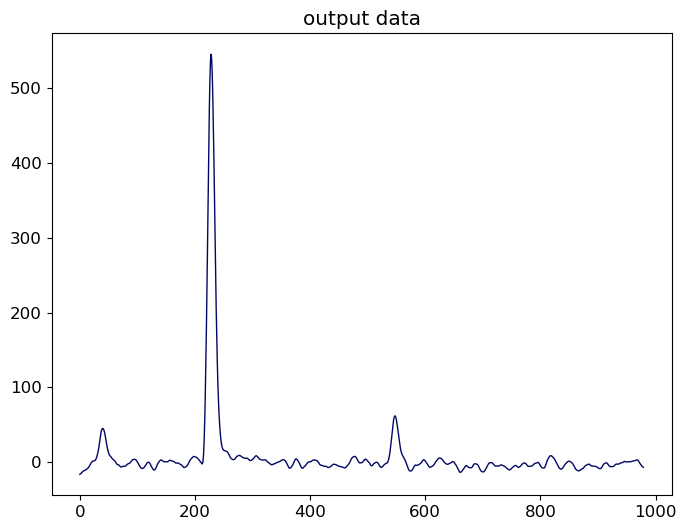

In [334]:
output = torch.tensor(output, dtype = torch.float)

#plot the graph
plt.figure()
plt.plot(torch.flatten(data),color='xkcd:darkblue',lw=1)
plt.title("input data")
plt.show()

plt.figure()
plt.plot(torch.flatten(output),color='xkcd:darkblue',lw=1)
plt.title("output data")
plt.show()

As we can see from the output data, for the specific kernel we pick, it smoothes out the original input data and pick out the peaks from the input data as expected.

In [335]:
# first of all define the net we are going to use
class Conv1DNet(nn.Module):
    global dim
    def __init__(self, kernel_size_1, kernel_size_2, pool_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1,3,kernel_size_1)
        self.conv2 = nn.Conv1d(3,6,kernel_size_2)
        self.pool  = nn.MaxPool1d(pool_size)
        dim = int((int((1001-kernel_size_1)/pool_size) - kernel_size_2+1)/pool_size) # the size of the data after 2 Conv1D and Maxpooling
        self.L1 = nn.Linear(dim*6, 64)
        self.L2 = nn.Linear(64,32)
        self.L3 = nn.Linear(32,2)
    
    def forward(self, x):
        x = torch.tensor(x, dtype = self.conv1.weight.dtype)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape) # for the purpose of debugging
        x = torch.flatten(x,1)
        #print(x.shape)
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = self.L3(x)
        return x

In [342]:
import torch.optim as optim

def train(epoch_num,net,learning_rate,momentum,verbose = True):
    # define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(),lr = learning_rate,momentum=momentum)
    loss_list = [] #keep track of the loss
    for epoch in range(epoch_num): #loop over the data epoch_num times
        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
            x,label = data
            optimizer.zero_grad()
            #train the model
            pred = net(x)
            loss = criterion(pred,label)
            loss.backward()
            optimizer.step()
            #print statistics on loss
            running_loss += loss.item()
            if i % 200 == 199:# print every 200 mini-batches
                if verbose == True:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
                loss_list.append(running_loss/200)
                running_loss = 0.0
    print("Finish training")
    return loss_list

def validation_accuracy(net, validation_loader):
    # test the accuracy on the validation data set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validation_loader:
            x,label = data
            #calculate the output
            output = net(x)
            #the item with highest probability is the prediction
            _, prediction = torch.max(output,1)
            total += label.size(0)
            correct += (prediction == label).sum().item()
    print(f'Accuracy of the network on the {len(validation_loader)*batch_size} test images: {100 * correct // total} %')
    return

In [343]:
#visualize the net
from torchsummary import summary
net = Conv1DNet(40,40,5)
summary(net,(1,1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 3, 961]             123
         MaxPool1d-2               [-1, 3, 192]               0
            Conv1d-3               [-1, 6, 153]             726
         MaxPool1d-4                [-1, 6, 30]               0
            Linear-5                   [-1, 64]          11,584
            Linear-6                   [-1, 32]           2,080
            Linear-7                    [-1, 2]              66
Total params: 14,579
Trainable params: 14,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.06
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


Finish training


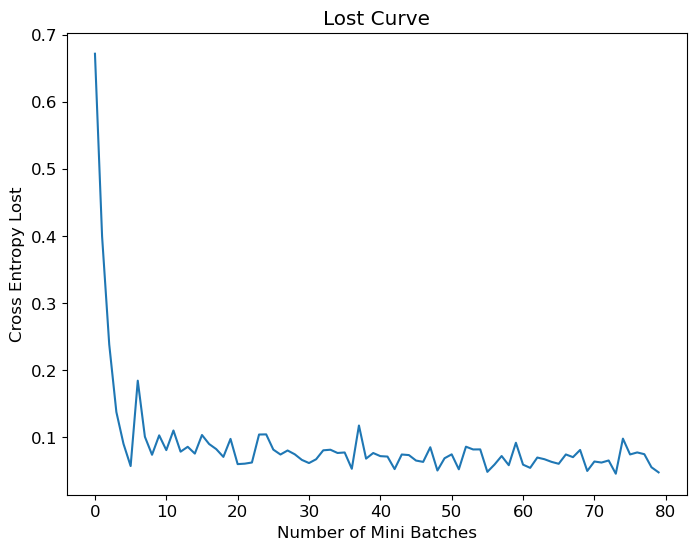

In [344]:
# train the net
loss_list = train(10,net,1e-3,0.9,verbose = False)
plt.figure()
plt.xlabel("Number of Mini Batches")
plt.ylabel("Cross Entropy Lost")
plt.title("Lost Curve")
plt.plot(loss_list)
plt.show()

we can infer from the lost curve that the training model is working properly. And now we can test the score on the validation set, note that we do not test it on the test set for we do not wish to taint the test set.

In [345]:
validation_accuracy(net, val_loader)

Accuracy of the network on the 3690 test images: 97 %


This accuarcy is satisfing, which means that it is higher than 95%, which is the benchmark value, but we can possibly aim for 99% accuracy by fine tuning the hyper parameters

In [318]:
len(val_loader)

738

In [322]:
len(train_loader)

1723